In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj
from datasets import load_from_disk
import yaml

from utils import reflect_points_to_left


In [6]:
predictions_path = "/grid/zador/home/benjami/brain-annotation/outputs/2024-11-04/16-15-17/test_brain_predictions.npy" # 64 cells
predictions_path = "/grid/zador/home/benjami/brain-annotation/outputs/2024-11-08/17-16-34/test_brain_predictions.npy" # single-cell model
ccf_files_path = "/grid/zador/data_norepl/Ari/transcriptomics/CCF_files"

In [7]:
pred_dict = np.load(predictions_path, allow_pickle=True).item()

In [4]:
[len(pred_dict['locations']), len(pred_dict['predictions'])], pred_dict.keys()

([426526, 426526],
 dict_keys(['locations', 'labels', 'predictions', 'indices']))

In [5]:
acc = (np.array(pred_dict['labels']) == np.array(pred_dict["predictions"])).sum() / len(pred_dict['labels'])
print("Accuracy", acc)

Accuracy 0.30159943356325286


In [3]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)

bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
    hemisphere='right_for_both',
    view_space_for_other_hemisphere='flatmap_butterfly',
)

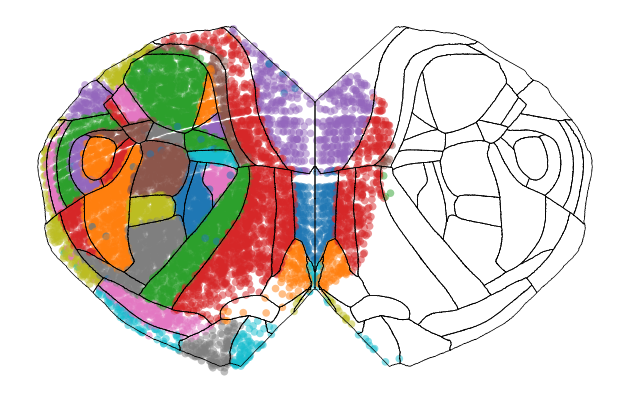

In [7]:
n=1000000
every = 50

categories = np.unique(pred_dict['labels'])
color_idx = [categories.tolist().index(j) for j in pred_dict['labels'][:n:every]]

cs = np.array(sns.color_palette("tab10", len(categories)))

plt.scatter(np.array(pred_dict['locations'])[:n:every,0], np.array(pred_dict['locations'])[:n:every,1], color=cs[color_idx], 
            alpha=.5, linewidths=0, s=30)

plt.grid(False)
for k, boundary_coords in bf_left_boundaries_flat.items():
    plt.plot(*boundary_coords.T, c="k", lw=0.5)
for k, boundary_coords in bf_right_boundaries_flat.items():
    plt.plot(*boundary_coords.T, c="k", lw=0.5)

plt.axis('off')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("single_cell_test_brain_labels.png")
plt.show()


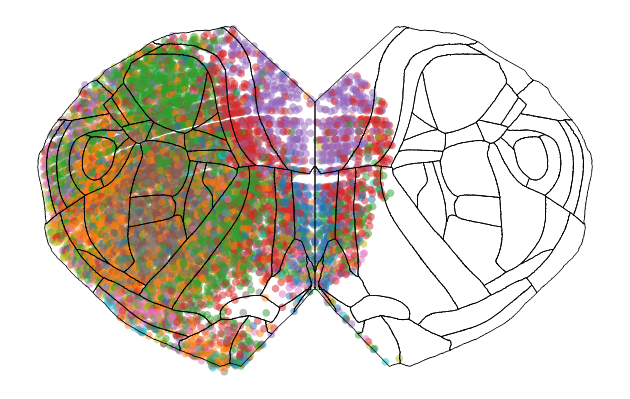

In [8]:
n=1000000
every = 50

categories = np.unique(pred_dict['labels'])
color_idx = [categories.tolist().index(j) for j in pred_dict['predictions'][:n:every]]

cs = np.array(sns.color_palette("tab10", len(categories)))

plt.scatter(np.array(pred_dict['locations'])[:n:every,0], np.array(pred_dict['locations'])[:n:every,1], color=cs[color_idx], 
            alpha=.5, linewidths=0, s=30)

plt.grid(False)
for k, boundary_coords in bf_left_boundaries_flat.items():
    plt.plot(*boundary_coords.T, c="k", lw=0.5)
for k, boundary_coords in bf_right_boundaries_flat.items():
    plt.plot(*boundary_coords.T, c="k", lw=0.5)

plt.axis('off')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("single_cell_test_brain_predictions.png")
plt.show()


## Stratify by cell type

In [4]:
from utils import get_colormap, compute_hierarchical_averages

adata_path = "/grid/zador/data_norepl/Ari/transcriptomics/barseq/Chen2023/filt_neurons_D079_3L_CCFv2_newtypes.h5ad"
adata = ad.read_h5ad(adata_path)


In [8]:
idx = pred_dict['indices']

# load the dataset
dataset_path = "/grid/zador/data_norepl/Ari/transcriptomics/barseq/Chen2023/train_test_barseq.dataset"
dataset = load_from_disk(dataset_path)

test_dataset = dataset['test']#[idx]



In [9]:


results_df = pd.DataFrame(columns=[ 'labels', 'predictions', 'indices',
                                   'H2_type', 'CCFano', 'H3_type', 'CCF', 'H1_type', 'CCFname', 'area_label'])

for key in  ['labels', 'predictions', 'indices', 'locations']:
    results_df[key] = pred_dict[key]

for key in ['H2_type', 'CCFano', 'H3_type', 'H1_type', 'CCFname', 'area_label']:
    results_df[key] = test_dataset[key]

results_df["Pct. correct"] = 100*(results_df["labels"] == results_df["predictions"])

results_df

,labels,predictions,indices,H2_type,CCFano,H3_type,CCF,H1_type,CCFname,area_label,locations,Pct. correct
0,80,246,0,NA,312782632.0,NA,NaN,Other,VISpor1,80,"[295.276231719279, 1108.8370887765152, 186.415...",0
1,80,243,1,L4/5 IT,312782632.0,L4/5 IT_5,NaN,Glutamatergic,VISpor1,80,"[300.79273599902155, 1109.5758271752497, 44.84...",0
2,80,246,2,NA,312782632.0,NA,NaN,Other,VISpor1,80,"[304.5866415612763, 1115.5555266453616, 141.11...",0
3,80,243,3,NA,312782632.0,NA,NaN,Other,VISpor1,80,"[311.56472990097933, 1111.676685941265, 7.5875...",0
4,80,246,4,NA,312782632.0,NA,NaN,Other,VISpor1,80,"[315.7465913766349, 1120.004960513373, 13.1412...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
426521,112,288,426521,L5 IT,1015.0,L5 IT_1,NaN,Glutamatergic,ACAd5,112,"[1323.2333594569388, 427.6041144527127, 44.289...",0
426522,112,112,426522,Low quality,1015.0,Low quality_2,NaN,Glutamatergic,ACAd5,112,"[1323.3154584046417, 427.76987125623856, 44.11...",100
426523,112,284,426523,NA,1015.0,NA,NaN,Other,ACAd5,112,"[1325.037922301616, 427.5005114318067, 45.7327...",0
426524,112,243,426524,Low quality,1015.0,Low quality_2,NaN,Glutamatergic,ACAd5,112,"[1326.08488903018, 430.1182060481286, 40.78199...",0


In [10]:
cmap_h3 = get_colormap(adata, "H3_type")
cmap_h1, cmap_h2 = compute_hierarchical_averages(results_df, cmap_h3)

/grid/zador/home/benjami/brain-annotation/figures/utils.py:61: UserWarning: Some H3 types in vectors not found in DataFrame and will be ignored: {'Unknown', 'BA_4', 'Low quality_15', 'AON_1', 'PG_6'}
  warnings.warn(f"Some H3 types in vectors not found in DataFrame and will be ignored: {unknown_h3}")


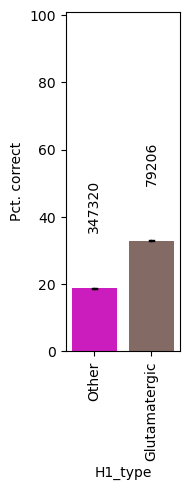

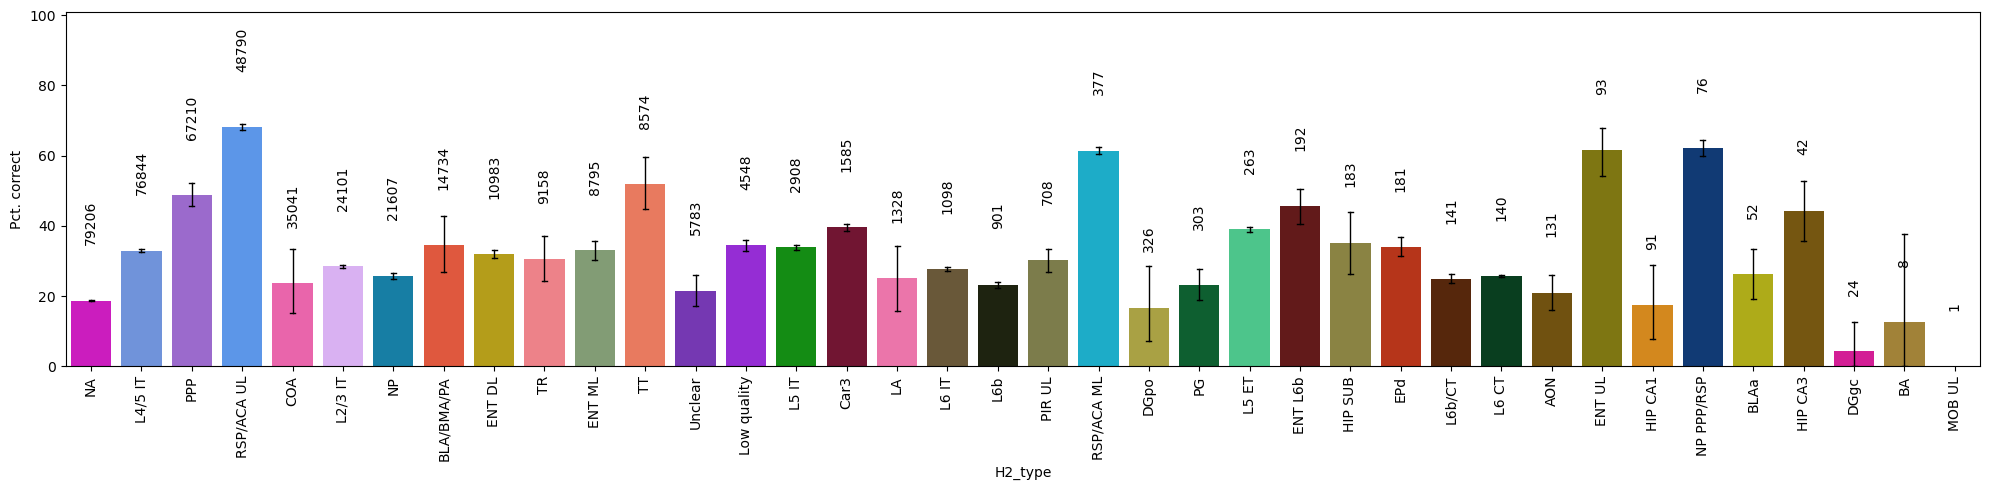

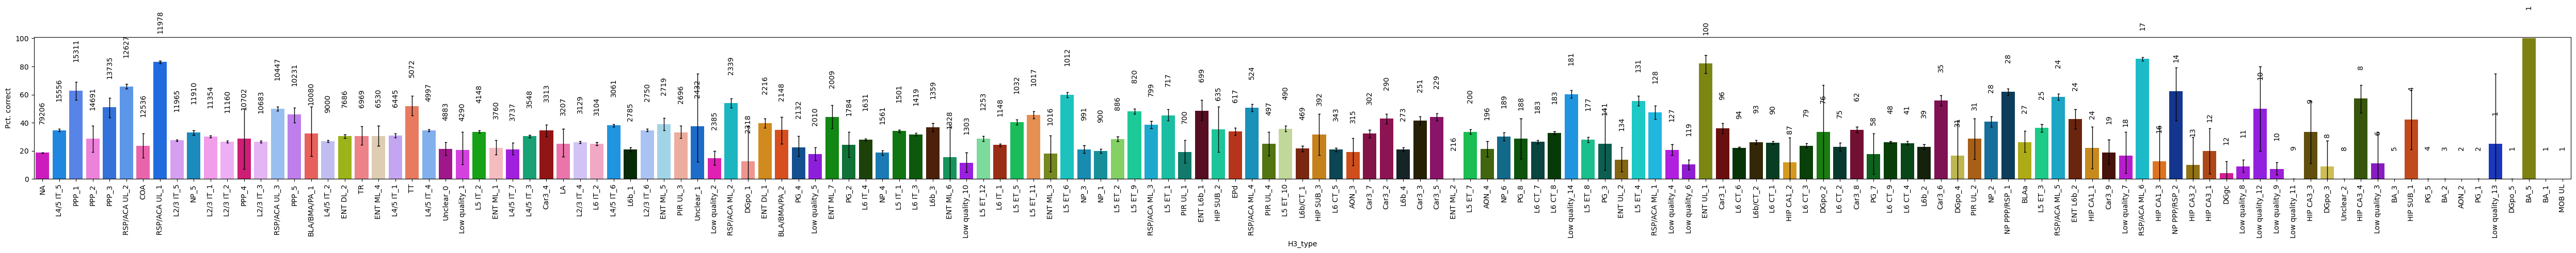

In [ ]:
figsizes = ((2,5), (20,5), (50,5))
cmaps = [cmap_h1, cmap_h2, cmap_h3]
for i,level in enumerate(["H1_type", "H2_type", "H3_type"]):
    plt.figure(figsize=figsizes[i])
    sns.barplot(x=level, y="Pct. correct", data=results_df, orient="v", errorbar=None)
    # x label rotation
    plt.xticks(rotation=90)
    # get counts of each category
    counts = results_df[level].value_counts()
    ax = plt.gca()
    ax.bar_label(ax.containers[0], labels=counts.values, label_type='edge', rotation=90, padding=20)
    sns.barplot(x=level, y="Pct. correct", data=results_df, orient="v", hue=level, palette=cmaps[i],
                err_kws={'linewidth':1, 'color':'k'},capsize=.1)
    plt.ylim([0, 101])
    plt.tight_layout()
    plt.savefig(f"single_cell_pct_correct_{level}.png")
    plt.show()
    


#### Plot out where each of these cell types is

/tmp/ipykernel_1602344/600169745.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[i%box, i//box].scatter(locs[:,0], locs[:,1], c=cmap_h2[cell_type], alpha=0.5, s=5)


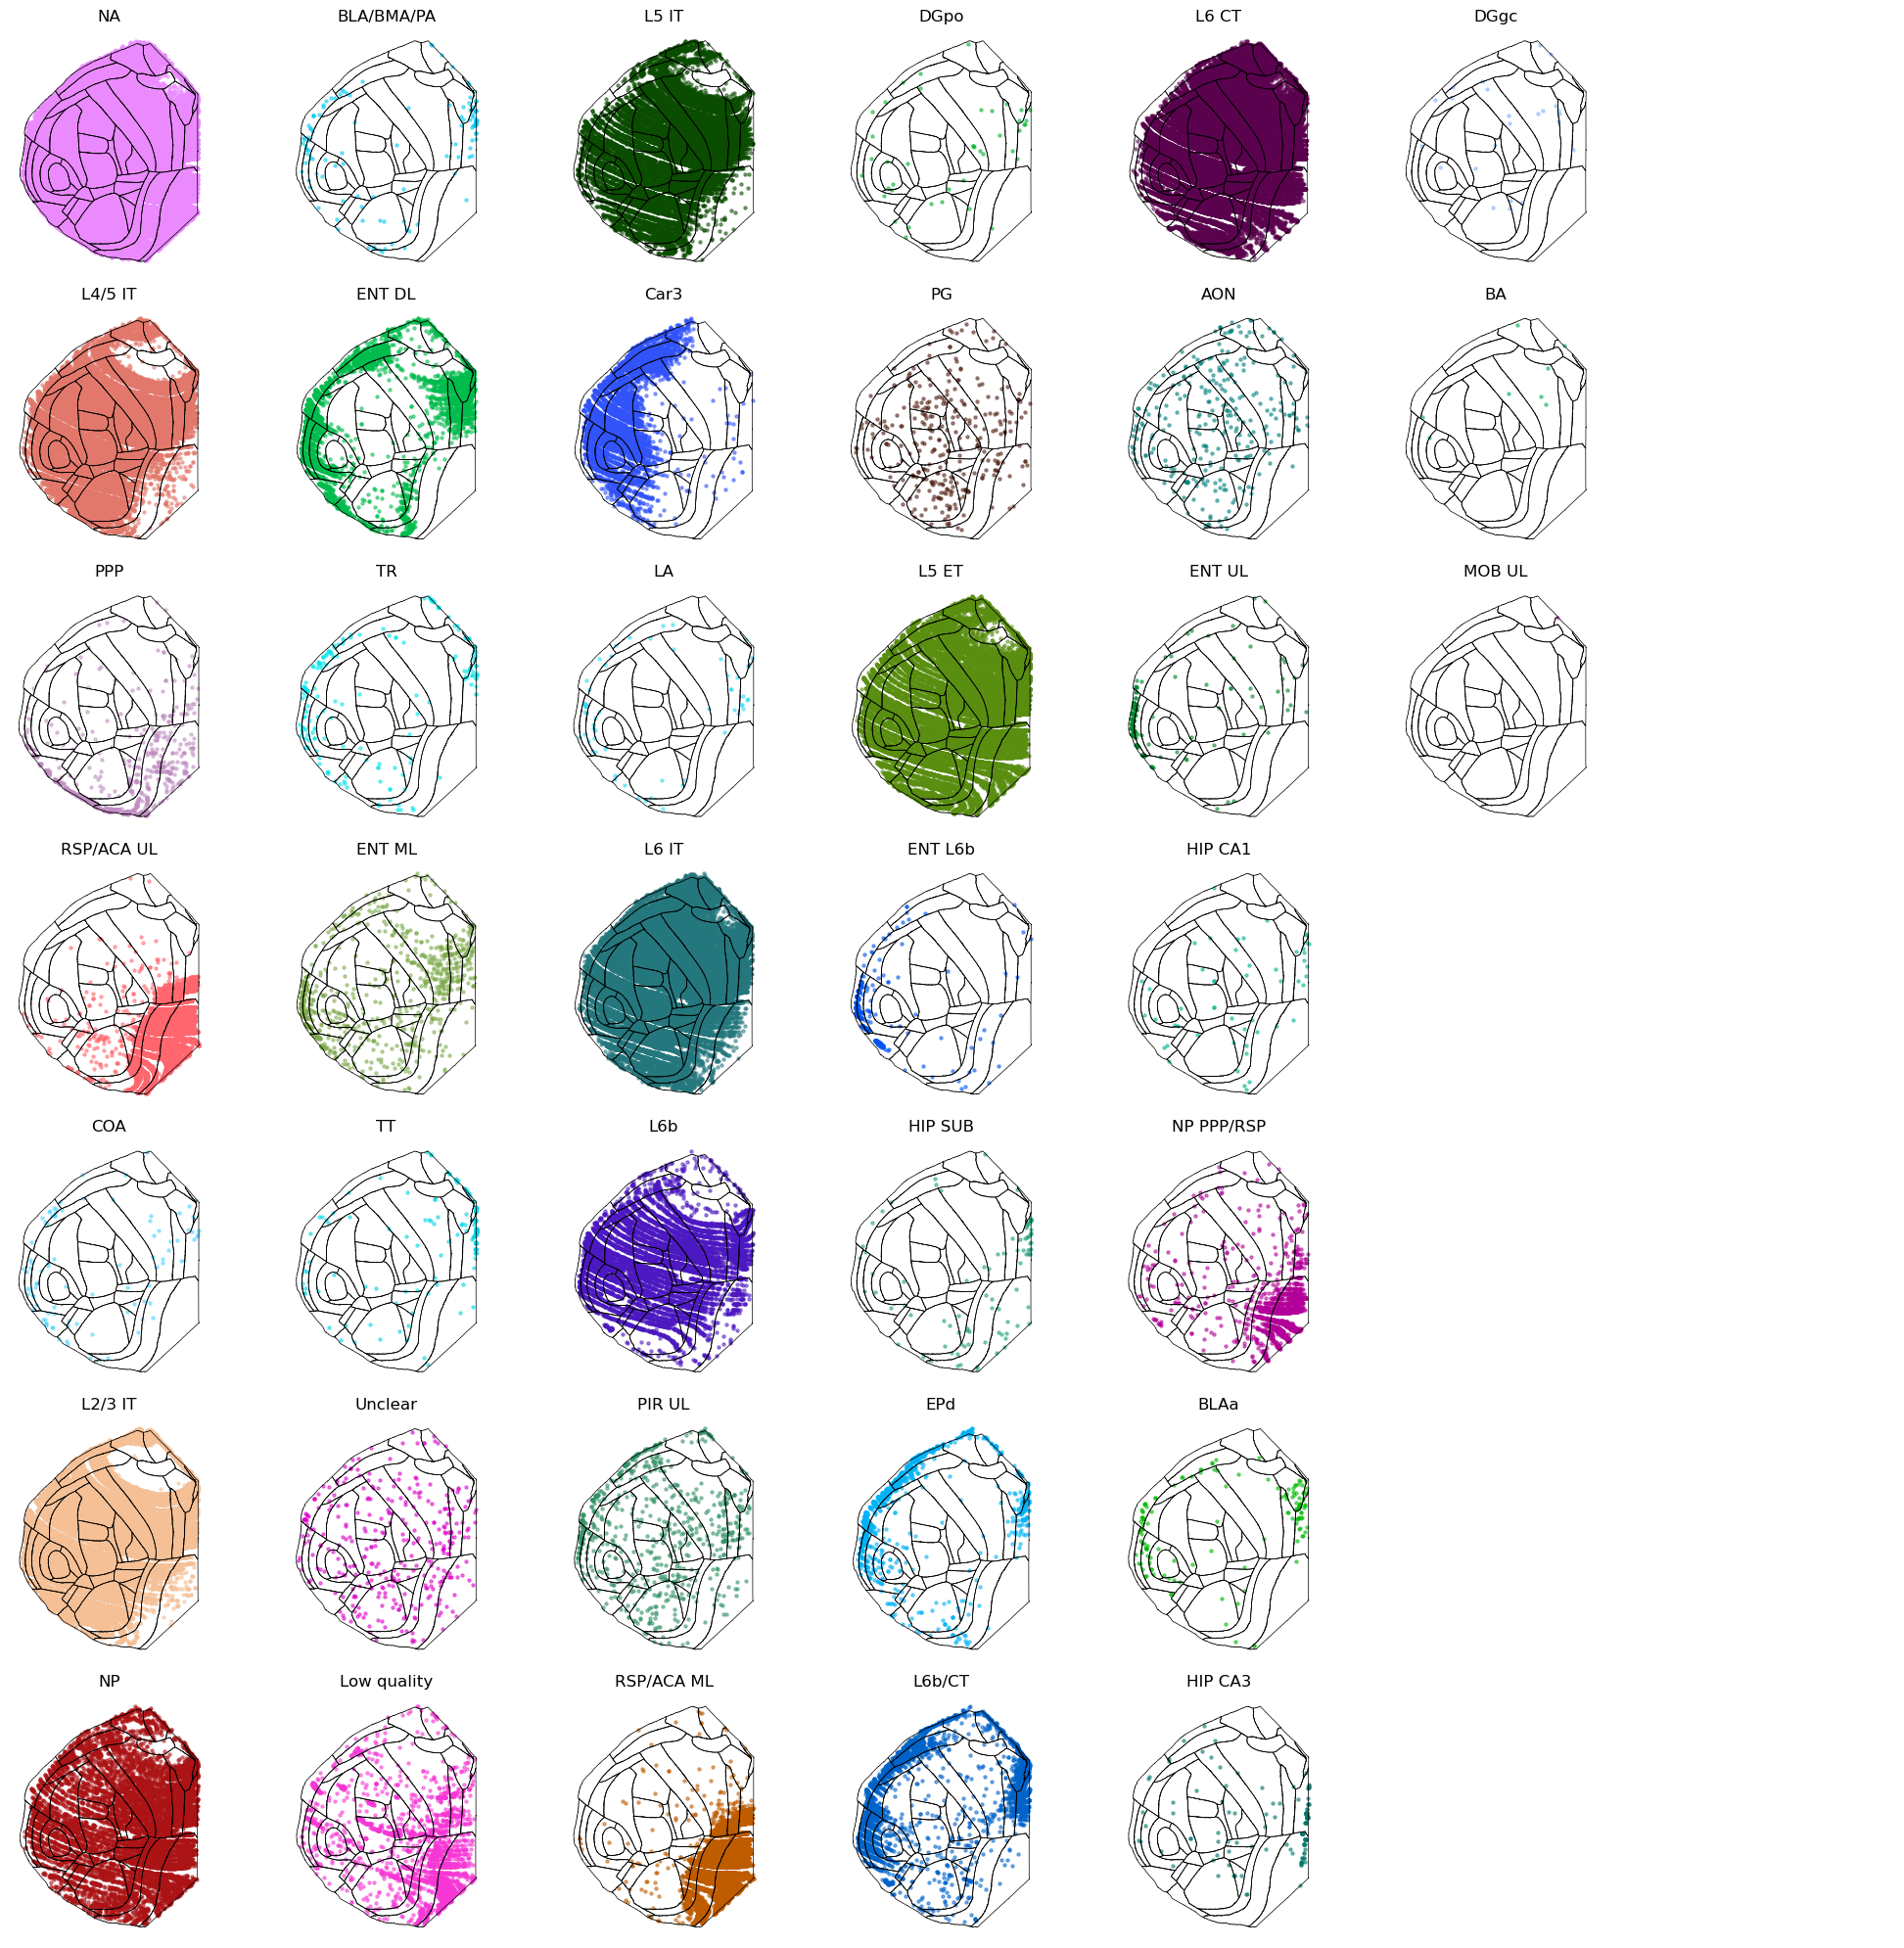

In [12]:
box = 7
f, ax = plt.subplots(box, box, figsize=(20,20),)

for i, cell_type in enumerate(results_df["H2_type"].unique()):
    idx = results_df["H2_type"] == cell_type
    locs = np.stack(results_df['locations'])[idx]
    locs = reflect_points_to_left(locs)
    ax[i%box, i//box].scatter(locs[:,0], locs[:,1], c=cmap_h2[cell_type], alpha=0.5, s=5)
    ax[i%box, i//box].set_title(cell_type)
    ax[i%box, i//box].grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        ax[i%box, i//box].plot(*boundary_coords.T, c="k", lw=0.5)
    # invert y axis
    ax[i%box, i//box].invert_yaxis()


for i in range(box):
    for j in range(box):
        ax[i,j].axis('off')
        ax[i,j].set_aspect('equal')
plt.tight_layout()
plt.savefig("h2_types_location.png")


## Performance convergence by cell type

In [4]:

def extract_data_from_folders(base_paths):
    # Initialize an empty list to store the results
    results = []

    if not isinstance(base_paths, list):
        base_paths = [base_paths]

    # Iterate through the folders
    for base_path in base_paths:
        for folder in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder)
            if os.path.isdir(folder_path):
                # Load the config.json file
                config_path = os.path.join(folder_path, '.hydra', 'config.yaml')
                if os.path.exists(config_path):
                    with open(config_path, 'r') as f:
                        config = yaml.safe_load(f)

                    if config['debug']:
                        continue

                    group_size = config['data']['group_size']
                    if group_size > 64:
                        continue

                    # Iterate through the .npy files
                    for file in os.listdir(folder_path):
                        if file.startswith('cell_type_') and file.endswith('.npy'):
                            cell_type = file.split('_')[2]
                            file_path = os.path.join(folder_path, file)

                            # Load the .npy file
                            pred_dict = np.load(file_path, allow_pickle=True).item()

                            # Calculate the accuracy
                            acc = (np.array(pred_dict['labels']) == np.array(pred_dict['predictions'])).sum() / len(pred_dict['labels'])

                            # Append the result to the list
                            results.append({'group_size': group_size, 'cell_type': cell_type, 'accuracy': acc})

    # Convert the results to a DataFrame
    df = pd.DataFrame(results)
    return df

# Example usage
base_paths = ['/grid/zador/home/benjami/brain-annotation/outputs/2024-11-13','/grid/zador/home/benjami/brain-annotation/outputs/2024-11-14']
df = extract_data_from_folders(base_paths)
df

,group_size,cell_type,accuracy
0,8,NA,0.305354
1,8,L5IT,0.458519
2,8,RSPACAML,0.732484
3,8,Car3,0.446312
4,8,L5ET,0.506640
...,...,...,...
190,8,ENTDL,0.487535
191,8,L6b,0.355769
192,8,L23IT,0.404685
193,8,L6IT,0.397260


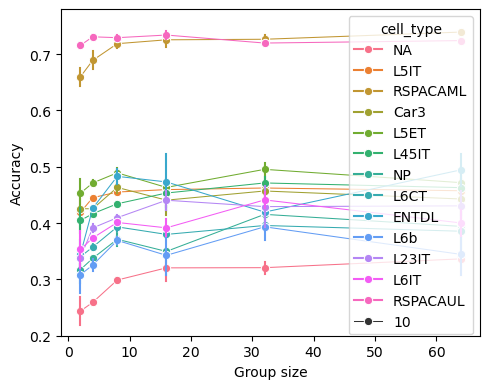

In [9]:
plt.figure(figsize=(5, 4))
sns.lineplot(df, x='group_size',y='accuracy',hue='cell_type', size=10, marker='o', errorbar='se', err_style='bars')
plt.ylabel('Accuracy')
plt.xlabel('Group size')
plt.ylim([.2,.78])
plt.tight_layout()
plt.savefig("cell_type_group_size_accuracy.png")
plt.savefig("cell_type_group_size_accuracy.pdf")
plt.show()

### Plot confusion matrix

In [52]:
with open('../data/files/area_ancestor_id_map.json', 'r') as f:
    area_ancestor_id_map = json.load(f)
with open('../data/files/area_name_map.json', 'r') as f:
    area_name_map = json.load(f)
area_name_map['0'] = 'outside_brain'
annotation2area_int = {0.0:0} # Map from annotation id to area id. Float to int
for a in area_ancestor_id_map.keys(): 
    higher_area_id = area_ancestor_id_map[str(int(a))][1] if len(area_ancestor_id_map[str(int(a))])>1 else a    
    annotation2area_int[float(a)] = higher_area_id

unique_areas = np.unique(list(annotation2area_int.values())) # List of unique areas (noncontiguous ints)
unique_annos = [area_name_map[str(int(a))] for a in unique_areas] # List of unique area names
area_classes = np.arange(len(unique_areas)) # Create a class for each area (0, 1, 2, ...)
id2id = {float(k):v for (k,v) in zip(unique_areas, area_classes)} # Map from area id to class id
annoation2area_class = {k: id2id[int(v)] for k,v in annotation2area_int.items()} # Map from annotation to area class
id2id_rev = {v:k for k,v in id2id.items()} # Map from class id to area id
area_class2area_name = {k: area_name_map[str(int(v))] for k,v in id2id_rev.items()} # Map from area class to area name

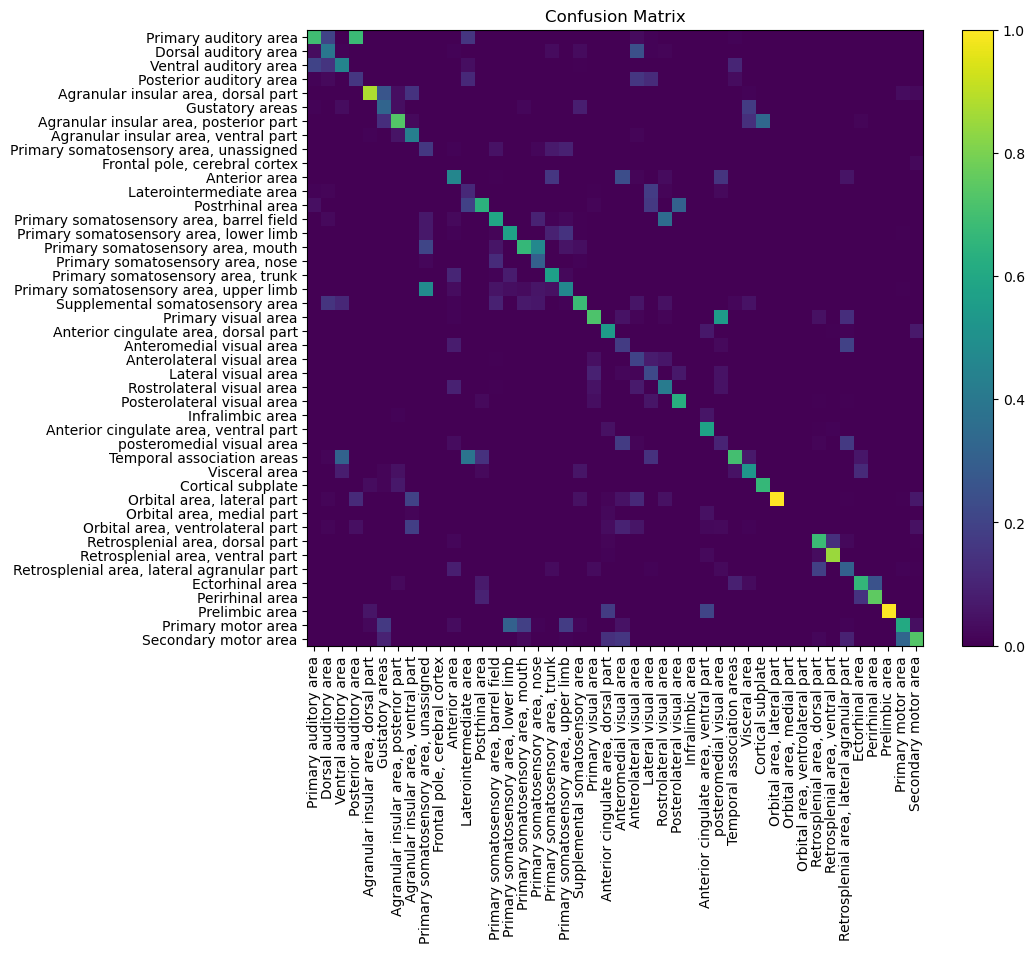

In [55]:
# get confusion matrix using sklearn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pred_dict['labels'], pred_dict['predictions'], normalize='pred')
area_names = [area_class2area_name[c] for c in categories]

cm_df = pd.DataFrame(cm, index=area_names, columns=area_names)

# Plot confusion matrix using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cm_df, interpolation='none', cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(area_names))
plt.xticks(tick_marks, area_names, rotation=90);
plt.yticks(tick_marks, area_names);
                      